## Power Method - Page Rank

#### Corduneanu-Huci Maria, Dzhekshenova Aiana, Kovács Renáta

### Import needed libraries

In [43]:

import networkx as nx
from networkx import NetworkXError
import matplotlib.pyplot as plt

### PageRank 

In [44]:
def pagerank(G, alpha=0.85, personalization=None,
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight',
             dangling=None):
    """Return the PageRank of the nodes in the graph"

    Parameters
    ----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.

    alpha : float, optional
      Damping parameter for PageRank, default=0.85.

    personalization: dict, optional
      The "personalization vector" consisting of a dictionary with a
      key for every graph node and nonzero personalization value for each node.
      By default, a uniform distribution is used.

    max_iter : integer, optional
      Maximum number of iterations in power method eigenvalue solver.

    tol : float, optional
      Error tolerance used to check convergence in power method solver.

    nstart : dictionary, optional
      Starting value of PageRank iteration for each node.

    weight : key, optional
      Edge data key to use as weight.  If None weights are set to 1.

    dangling: dict, optional
      The outedges to be assigned to any "dangling" nodes, i.e., nodes without
      any outedges. The dict key is the node the outedge points to and the dict
      value is the weight of that outedge. By default, dangling nodes are given
      outedges according to the personalization vector (uniform if not
      specified). This must be selected to result in an irreducible transition
      matrix (see notes under google_matrix). It may be common to have the
      dangling dict to be the same as the personalization dict.

    Returns
    -------
    pagerank : dictionary
       Dictionary of nodes with PageRank as value
      
    """
    if len(G) == 0:
        return {}

    if not G.is_directed():
        D = G.to_directed()
    else:
        D = G

    # Create a copy in (right) stochastic form
    W = nx.stochastic_graph(D, weight=weight)
    N = W.number_of_nodes()

    # Choose fixed starting vector if not given
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)
    else:
        # Normalized nstart vector
        s = float(sum(nstart.values()))
        x = dict((k, v / s) for k, v in nstart.items())

    if personalization is None:

        # Assign uniform personalization vector if not given
        p = dict.fromkeys(W, 1.0 / N)
    else:
        missing = set(G) - set(personalization)
        if missing:
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(personalization.values()))
        p = dict((k, v / s) for k, v in personalization.items())

    if dangling is None:

        # Use personalization vector if dangling vector not specified
        dangling_weights = p
    else:
        missing = set(G) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(dangling.values()))
        dangling_weights = dict((k, v/s) for k, v in dangling.items())
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]

    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
        for n in x:
            for nbr in W[n]:
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n]

        # check convergence, l1 norm
        err = sum([abs(x[n] - xlast[n]) for n in x])
        if err < N*tol:
            return x
    raise NetworkXError('pagerank: power iteration failed to converge '
                        'in %d iterations.' % max_iter)

###### code for the PageRank algorithm from: https://www.geeksforgeeks.org/python/page-rank-algorithm-implementation/

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.

The eigenvector calculation is done by the power iteration method and has no guarantee of convergence.  The iteration will stop after max_iter iterations or an error tolerance of number_of_nodes(G)*tol has been reached.
The PageRank algorithm was designed for directed graphs but this algorithm does not check if the input graph is directed and will execute on undirected graphs by converting each edge in the directed graph to two edges.


### Simple example

In [50]:
G = nx.DiGraph()
G.add_edge("A", "B", weight=1)
G.add_edge("A", "C", weight=1)
G.add_edge("B", "C", weight=1)
G.add_edge("C", "A", weight=1)
G.add_edge("C", "B", weight=1)
G.add_edge("D", "B", weight=1)
G.add_edge("E", "C", weight=1)
G.add_edge("C", "E", weight=1)

ranks = pagerank(G, alpha=0.85)
print(ranks)

{'A': 0.15103793293867185, 'B': 0.24072941611763246, 'C': 0.42719471800502384, 'D': 0.030000000000000006, 'E': 0.15103793293867185}


- C has the highest importance $\rightarrow$ 0.42719471800502384
- B has the second importance $\rightarrow$ 0.24072941611763246
- E has the third importance $\rightarrow$ 0.15103793293867185
- A has the same importance as E $\rightarrow$ 0.15103793293867185
- D has the least importance $\rightarrow$ 0.030000000000000006

The power method converges to the principal eigenvector: e=(0.15103, 0.2407, 0.4272, 0.03, 0.15103)

If a "random web surfer" follows links forever, the probability of ending up on each page is the PageRank value.

$\Rightarrow$

- A: 23.4% chance
- B: 33.3% chance
- C: 43.3% chance

C is the most “popular” node in the network

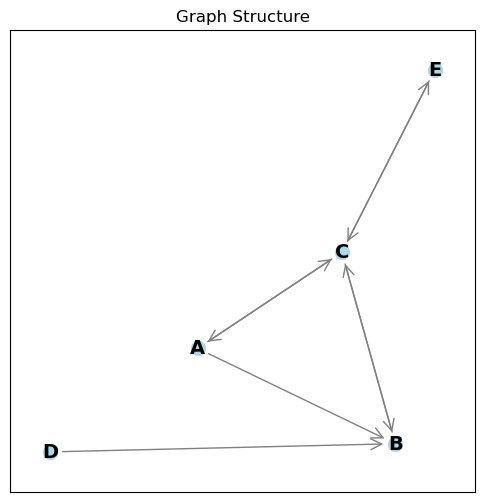

In [53]:
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # layout for nice spacing

nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')

plt.title("Graph Structure")
plt.axis()
plt.show()

C is the most important node because:
- it receives links from A, B, and E
- it sends links out to A, B, and E $\Rightarrow$ it spreads importance

C is a hub

### Barabasi Albert Graph

Barabasi Albert model is built on two rules: the network grows over time, and new nodes follow preferential attachment. This means they're more likely to connect to nodes that are already popular. It’s a 'rich get richer' effect. This single recipe is brilliant at creating one thing: massive hubs. It gives us a Power Law distribution, which explains the 'superstar' nodes we see in reality. A network with this property is called scale free.

In [62]:
#creates a Barabási–Albert graph with 60 nodes and each new node attaches to 5 existing nodes
G=nx.barabasi_albert_graph(60,52)
pr=nx.pagerank(G,0.4)
pr

{0: 0.04730243023136032,
 1: 0.01224250758453151,
 2: 0.012563954986235056,
 3: 0.011603676383150005,
 4: 0.01224250758453151,
 5: 0.012563954986235056,
 6: 0.011287335489753391,
 7: 0.01224006652741533,
 8: 0.012563954986235056,
 9: 0.012563954986235056,
 10: 0.012241865034691435,
 11: 0.012563954986235056,
 12: 0.01224006652741533,
 13: 0.012563954986235056,
 14: 0.012563954986235056,
 15: 0.012563954986235056,
 16: 0.012563954986235056,
 17: 0.01224006652741533,
 18: 0.01224006652741533,
 19: 0.012563954986235056,
 20: 0.012563954986235056,
 21: 0.011919425364681924,
 22: 0.012563954986235056,
 23: 0.012563954986235056,
 24: 0.012563954986235056,
 25: 0.012563954986235056,
 26: 0.012563954986235056,
 27: 0.012563954986235056,
 28: 0.012563954986235056,
 29: 0.012563954986235056,
 30: 0.012563954986235056,
 31: 0.012241865034691435,
 32: 0.011918619125711783,
 33: 0.012563954986235056,
 34: 0.01224250758453151,
 35: 0.012563954986235056,
 36: 0.012563954986235056,
 37: 0.012244806647

A Barabási–Albert graph is generated using preferential attachment, meaning new nodes are more likely to connect to nodes that already have many connections. This naturally produces a scale-free degree distribution where a few nodes become hubs, having significantly more links than the rest

Page rank vector:

$p = \alpha M p + (1−\alpha) v$

This is an eigenvector equation corresponding to the dominant eigenvector of the modified transition matrix. The solution to this equation gives the steady-state probabilities that a random walker ends up on each node.

The power method is a simple iterative algorithm used to compute the dominant eigenvector of a matrix. PageRank is computed exactly by repeatedly applying the power method to the Google matrix:

$p^{k+1} = \alpha M p^{k} + (1−\alpha) v$

Because BA graphs naturally produce strong hubs, the power method converges quickly to a PageRank vector where those hubs dominate.
By generating a Barabási–Albert graph and applying PageRank, we directly use the power method to compute node importance in a scale-free network. The method highlights the emergence of central hubs, and the visualization shows how the iteration distributes influence across the network:

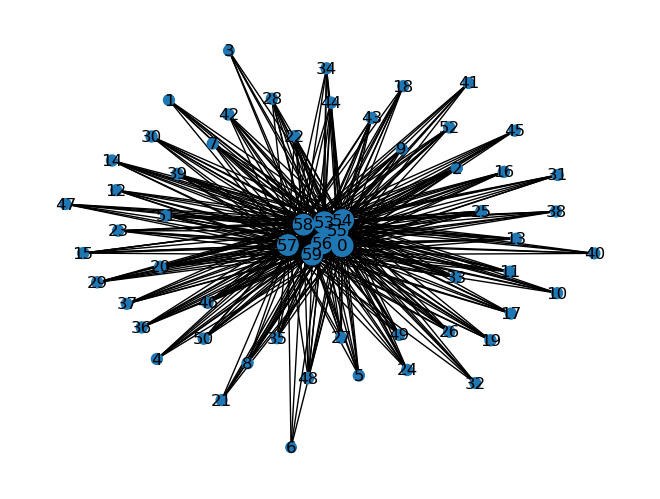

In [63]:
pos = nx.spring_layout(G)
sizes = [5000 * pr[i] for i in G.nodes()]
nx.draw(G, pos, with_labels=True, node_size=sizes)
plt.show()

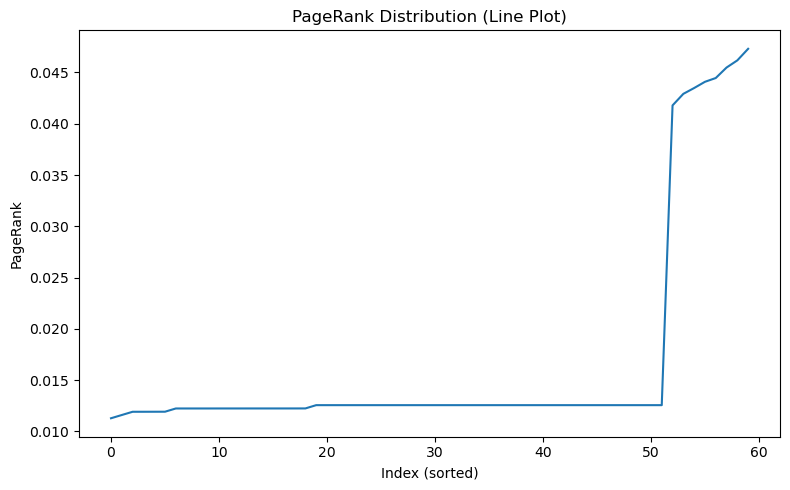

In [64]:
import matplotlib.pyplot as plt
import numpy as np

values = np.sort(list(pr.values())) #gives all the PageRank scores and turns them into a list

plt.figure(figsize=(8, 5))
plt.plot(values)
plt.xlabel("Index (sorted)")
plt.ylabel("PageRank")
plt.title("PageRank Distribution (Line Plot)")
plt.tight_layout()
plt.show()

The distribution of PageRank values:
- the line will rise slowly at first (many low PageRank nodes)
- the line will rise very fast at the end (few high PageRank nodes).

A Barabási–Albert graph typically has a long tail: most nodes have low PageRank, a few nodes have very high PageRank

For a better visualization: 

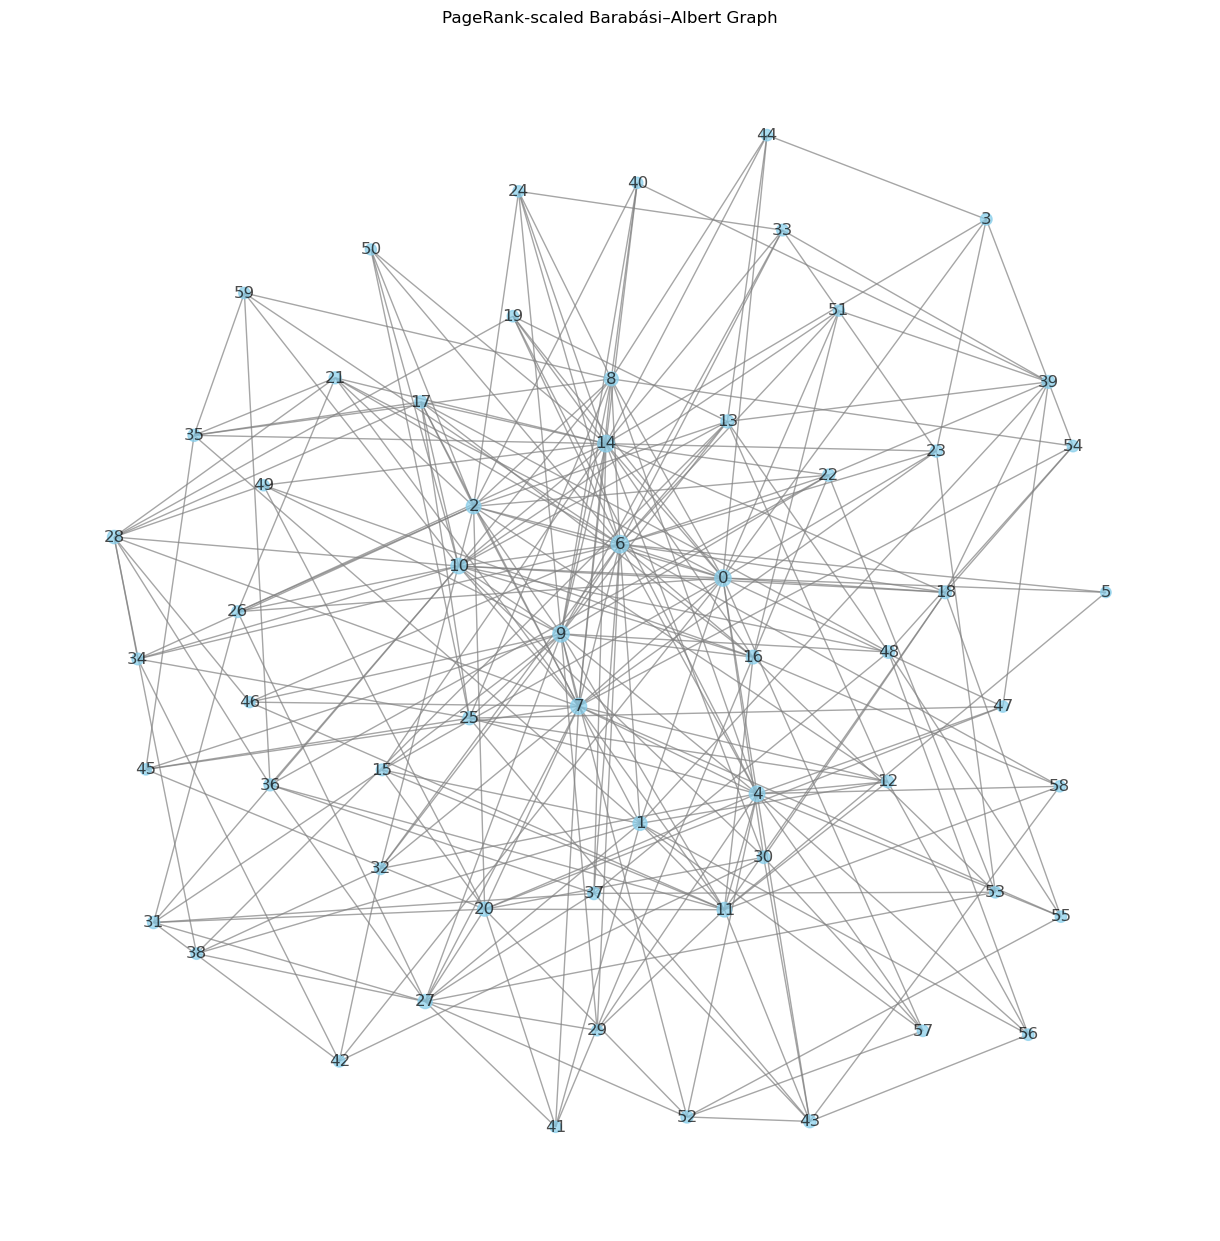

In [ ]:
G=nx.barabasi_albert_graph(60,5)
pr=nx.pagerank(G,0.4)

sizes = [5000 * pr[i] for i in G.nodes()]  #makes the size proportional

#reduces edge crossing and show structure clearly
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=sizes, node_color='skyblue', edge_color='gray', alpha=0.7)
plt.title("PageRank-scaled Barabási–Albert Graph")
plt.show()